In [1]:
import sys
if not '..' in sys.path:
    sys.path.insert(0, '..')
import control
import sympy
import numpy as np
import matplotlib.pyplot as plt
import ulog_tools as ut
from urllib.request import urlopen
import pyulog

%matplotlib inline
%load_ext autoreload
%autoreload 2

# System Identification

In [2]:
def model_to_acc_tf(m):
    # open loop, rate output, mix input plant
    acc_tf = m['gain'] * control.tf(*control.pade(m['delay'], 1))  # order 1 approx
    tf_integrator = control.tf((1), (1, 0))
    return acc_tf * tf_integrator

def pid_design(G_rate_ol, d_tc=1.0/125, K0=[0.01, 0.01, 0.01, 5]):
    K_rate, G_cl_rate, G_ol_rate_comp = ut.logsysid.pid_design(
        G_rate_ol, K0[:3], d_tc)
    tf_integrator = control.tf((1), (1, 0))
    K, G_cl, G_ol_comp = ut.logsysid.pid_design(
        G_cl_rate*tf_integrator, K0[3:], d_tc,
        use_I=False, use_D=False)
    return np.vstack([K_rate, K])

def pid_tf(use_P=True, use_I=True, use_D=True, d_tc=0.1):
    H = []
    if use_P:
        H += [control.tf(1, 1)]
    if use_I:
        H += [control.tf((1), (1, 0))]
    if use_D:
        H += [control.tf((1, 0), (d_tc, 1))]
    H = np.array([H]).T
    H_num = [[H[i][j].num[0][0] for i in range(H.shape[0])] for j in range(H.shape[1])]
    H_den = [[H[i][j].den[0][0] for i in range(H.shape[0])] for j in range(H.shape[1])]
    H = control.tf(H_num, H_den)
    return H

{'pitch': {'model': {'delay': 0.051503721021908873,
   'f_s': 232.99287433805779,
   'fit': 0.57135828178325399,
   'gain': 29.538700377173605,
   'sample_delay': 12},
  't_end': 80,
  't_start': 75},
 'roll': {'model': {'delay': 0.072963604781037569,
   'f_s': 232.99287433805779,
   'fit': 0.80970246387485934,
   'gain': 45.686738288604097,
   'sample_delay': 17},
  't_end': 105,
  't_start': 100},
 'yaw': {'model': {'delay': 0.11159139554746923,
   'f_s': 232.99287433805779,
   'fit': 0.87415539221919858,
   'gain': 41.274527427318752,
   'sample_delay': 26},
  't_end': 5,
  't_start': 0}}

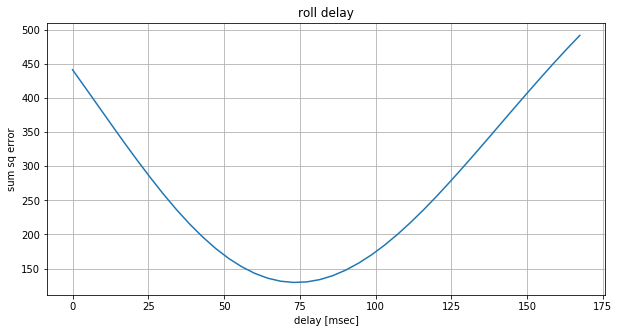

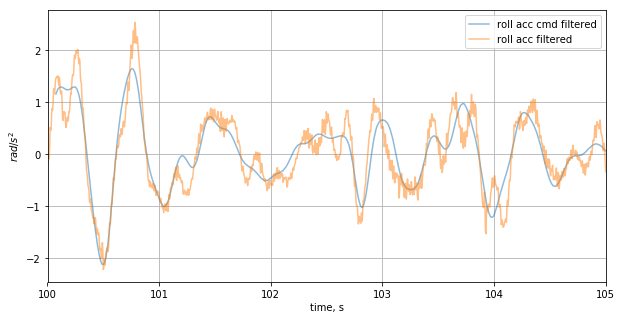

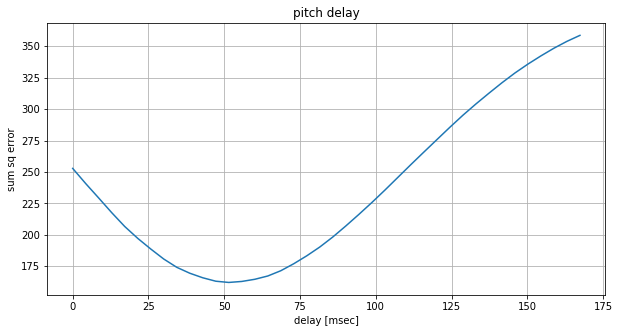

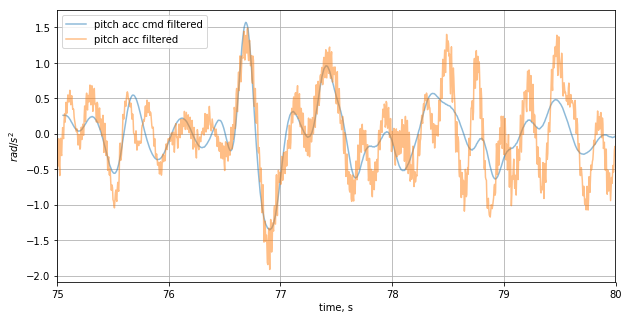

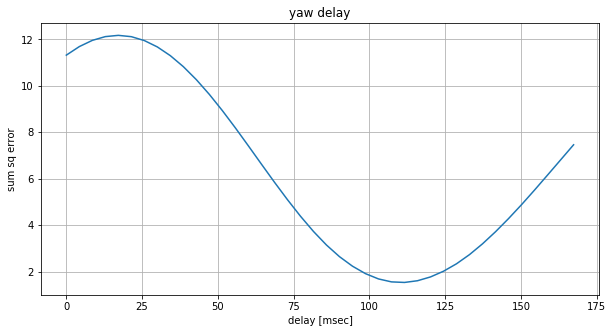

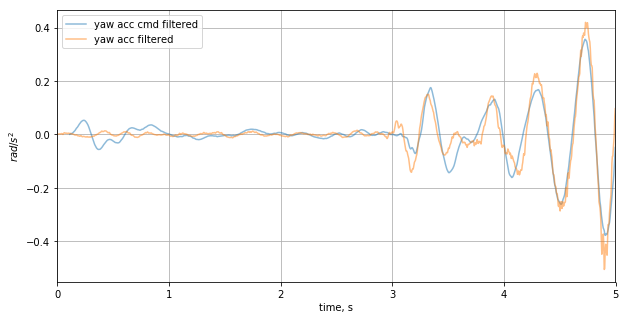

In [3]:
log_file = ut.ulog.download_log('http://review.px4.io/download?log=35b27fdb-6a93-427a-b634-72ab45b9609e', '/tmp')
data = ut.sysid.prepare_data(log_file)
res = ut.sysid.attitude_sysid(data)
res

# Continuous Time Optimization

In [4]:
def attitude_loop_design(m, name):
    d_tc = 1.0/10
    G_rate_ol = model_to_acc_tf(m)
    K0=[0.182, 1.9, 0.01]
    K_rate, G_rate_ol, G_rate_comp_cl = ut.logsysid.pid_design(
        G_rate_ol, [0.2, 0.2, 0], d_tc)
    tf_integrator = control.tf([1], [1, 0])
    G_ol = G_rate_comp_cl*tf_integrator
    K, G_ol, G_comp_cl = ut.logsysid.pid_design(
        G_ol, [1], d_tc,
        use_I=False, use_D=False)
    K_rate, K
    return {
        'MC_{:s}RATE_P'.format(name): K_rate[0, 0],
        'MC_{:s}RATE_I'.format(name): K_rate[1, 0],
        'MC_{:s}RATE_D'.format(name): K_rate[2, 0],
        'MC_{:s}_P'.format(name): K[0, 0],
    }

In [5]:
attitude_loop_design(res['roll']['model'], 'ROLL')

{'MC_ROLLRATE_D': 0.0063734754545666465,
 'MC_ROLLRATE_I': 0.19844682163683977,
 'MC_ROLLRATE_P': 0.20051094114484688,
 'MC_ROLL_P': 4.5843426190341647}

In [6]:
attitude_loop_design(res['pitch']['model'], 'PITCH')

{'MC_PITCHRATE_D': 0.015662896675004697,
 'MC_PITCHRATE_I': 0.48847645640076243,
 'MC_PITCHRATE_P': 0.51104029619426683,
 'MC_PITCH_P': 5.8666514695501988}

In [7]:
attitude_loop_design(res['yaw']['model'], 'YAW')

{'MC_YAWRATE_D': 0.017251069591687748,
 'MC_YAWRATE_I': 0.19498248018478978,
 'MC_YAWRATE_P': 0.18924319337905329,
 'MC_YAW_P': 3.598452484267229}